# All faces in all frames, with probabilities

In this notebook, MTCNN returns all the faces in every frame, along with their probability. 

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from IPython.display import HTML
import cv2
from fastai.core import *
from fastai.vision import *
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01b import *

### Data

In [ ]:
SOURCE = Path('../data/train_sample_videos/')

In [ ]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


### Modified `DetectionPipeline`

In [ ]:
class DetectionPipeline: 
    def __init__(self, detector=None, nf=None, bs=60, fsz=None):
        if detector is None: detector = self.default_detector()
        self.detector = detector
        self.nf, self.bs, self.fsz = nf, bs, fsz
    
    def default_detector(self):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        return MTCNN(device=device, image_size=256,
                     post_process=False, select_largest=False, keep_all=True)
        
    def get_sample(self, vlen, n_frames):
        if n_frames is None: return np.arange(0, vlen)
        else: return np.linspace(0, vlen - 1, n_frames).astype(int)
    
    def resize(self, frame, size):
        return frame.resize([int(d * size) for d in frame.size])
    
    def get_savepaths(self, filename, idxs, label=None, save_dir=None):
        if isinstance(filename, str): filename = Path(filename)
        if save_dir is None: save_dir = Path('./')
        if label is None: save_paths = [save_dir/f'{filename.stem}_{i:03d}.png' for i in idxs]
        else: save_paths = [save_dir/f'{filename.stem}_{i:03d}_{label}.png' for i in idxs]
        return [str(o) for o in save_paths]  
            
    def __call__(self, filename, label=None, save_dir=None):
        assert Path(filename).exists()
        vcap = cv2.VideoCapture(str(filename))
        vlen = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample = self.get_sample(vlen, self.nf)
        iframes, faces, probs = [], [], []
        ib, fb = [], []
        for i in progress_bar(range(vlen)):
            _ = vcap.grab()
            if i in sample:
                success, f = vcap.retrieve()
                if not success: continue
                f = PIL.Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
                if self.fsz is not None: f = self.resize(f, self.fsz)
                ib.append(i); fb.append(f)
                if len(fb) % self.bs == 0 or i == sample[-1]:
                    savepaths = self.get_savepaths(filename, ib, label, save_dir) if save_dir else None
                    faceb, probb = self.detector(fb, return_prob=True, save_path=savepaths)
                    iframes.extend(ib); faces.extend(faceb); probs.extend(probb)
                    ib, fb = [], []
        vcap.release()
        return iframes, faces, probs

### Function to plot all detected faces, if any, in multiple frames

In [ ]:
def plt_frames_faces(iframes, faces, probs):
    ncols = len(iframes)
    nrows = max(len(face) for face in faces if face is not None)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows))
    for axcol, iframe, faces_, probs_ in zip(axs.T, iframes, faces, probs):
        if faces_ is None:
            for i, ax in enumerate(axcol): 
                if i==0: ax.set_title(f'frame {iframe}')
                ax.yaxis.set_ticklabels([]); ax.yaxis.set_ticks([])
                ax.xaxis.set_ticklabels([]); ax.xaxis.set_ticks([])
            continue
            
        for i, (ax, f_, p_) in enumerate(itertools.zip_longest(axcol, faces_, probs_)):
            if p_: 
                ax.imshow(f_.permute(1, 2, 0).type(torch.uint8).numpy())
                ax.set_xlabel(f'prob = {p_:.4f}')
            if i==0: ax.set_title(f'frame {iframe}')
            ax.yaxis.set_ticklabels([]); ax.yaxis.set_ticks([])      
            ax.xaxis.set_ticklabels([]); ax.xaxis.set_ticks([])
            
    return fig, axs

### Face detection model+pipeline

In [ ]:
mtcnn_params = dict(device='cuda:0' if torch.cuda.is_available() else 'cpu',
                    image_size=256,
                    select_largest=False, post_process=False)
detector = MTCNN(keep_all=True, **mtcnn_params)

In [ ]:
facepipe = DetectionPipeline(nf=20)

### Example video: some frames have one person's face, some have two people's faces

In [ ]:
fn = SOURCE/annots.fname[20]
HTML(html_vid(fn))

In [ ]:
iframes, faces, probs = facepipe(fn)

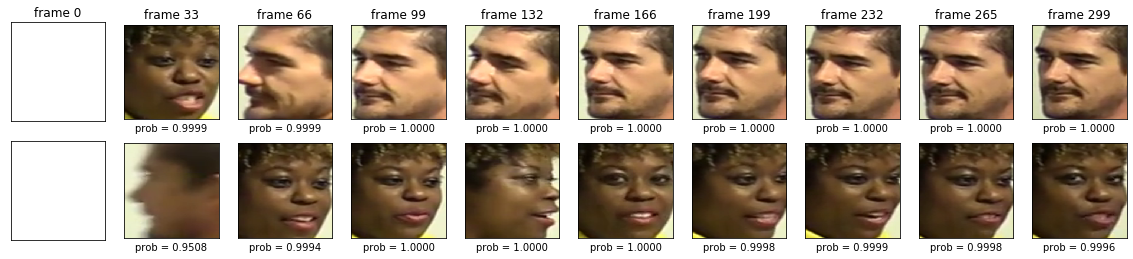

In [ ]:
fig, axs = plt_frames_faces(iframes, faces, probs)

### Example video: two people, one wearing a T-shirt with picture of a face

In [ ]:
fn = SOURCE/annots.fname[345]
fn

PosixPath('../data/train_sample_videos/edyncaijwx.mp4')

In [ ]:
HTML(html_vid(fn))

In [ ]:
iframes, faces, probs = facepipe(fn)

Can't keep the same person in the same row because the order of the faces returned by MTCNN is undetermined.  It's interesting to note that in the third row, whenever the person's hands/fingers are in front of the t-shirt, the probability is much higher.

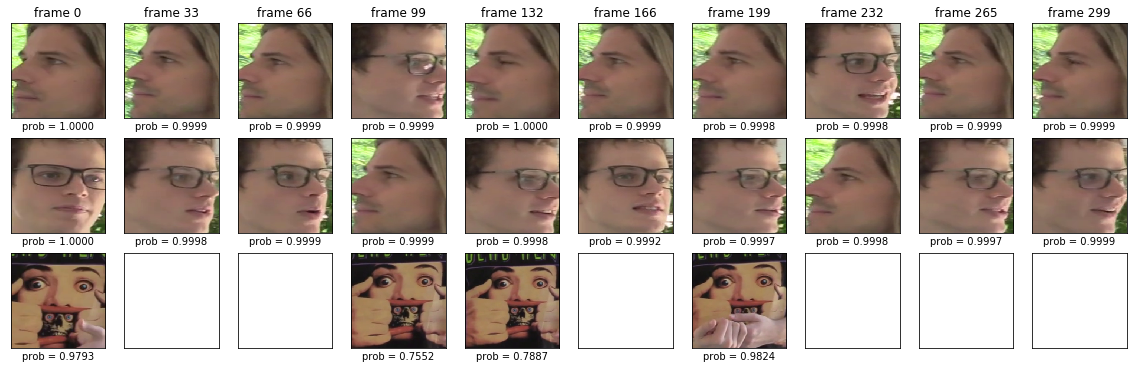

In [ ]:
fig, axs = plt_frames_faces(iframes, faces, probs)

### Example video: Where there is a rather realistic painting of a person on the wall behind the actor

The face on the painting can have a quite high probability, but obviously no deepfake technology has been applied there.

In [ ]:
fn = SOURCE/annots.fname[110]
fn

PosixPath('../data/train_sample_videos/bhaaboftbc.mp4')

In [ ]:
HTML(html_vid(fn))

In [ ]:
iframes, faces, probs = facepipe(fn)

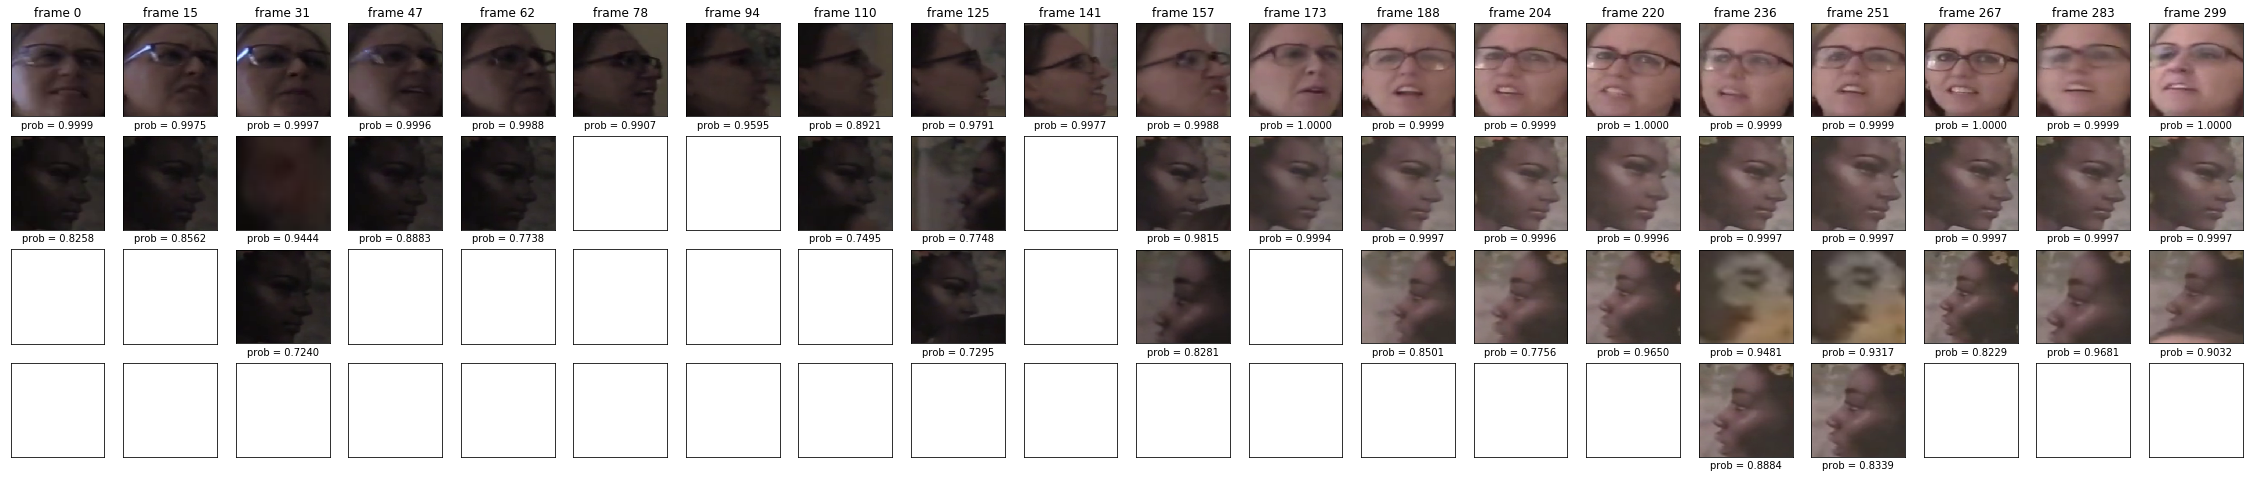

In [ ]:
_, _ = plt_frames_faces(iframes, faces, probs)

# - fin